In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import os, sys, re, pickle, glob
import urllib.request
import zipfile
from pathlib import Path

import IPython.display as ipd
from tqdm import tqdm
import librosa

# Elliot Linsey : 210764484 : Advanced Solution

We have been provided with a dataset containing audio files of either hums or whistles of recognisable songs or pieces of music. The purpose of this advanced solution is to create a machine learning pipeline that can predict whether an audio file fed into it is one of a number of pieces of music, these being themes from:
* The Lion King
* The Greatest Showman
* Star Wars
* Frozen
* Singing in the Rain
* Harry Potter
* The Pink Panther
* Mamma Mia

An interesting aspect of this particular dataset and problem in general, is that we do not have equal numbers of hums or whistles with there being far more hums in the dataset. Depending on what features we extract from the data, this may have an effect on our ability to predict what tune is being played.  

## Pipeline Description and Methodology

The pipeline will consist of an input stage, a transformation stage, feature extraction stage and a modelling stage leading to a prediction as the output. For the dataset we have received, some data cleaning techniques were used to rename all files into a pattern of "Participant ID" - "Interpretation Type (Whistle or Hum)" - "Interpretation Number (1-4)" - "Song Title". 

The input stage will take the raw .wav audio file, the transformation stage will conert the wav file into a numpy array using librosa, then shorten it to 15 seconds from the first onset. The feature extraction stage will extract the spectral centroids from the audio file. The model that will be used is a Random Forest Classifier to attempt to separate the classes by this feature and make a prediction. In addition to this, we shall use gridsearch and cross validation to find the optimal parameters for this problem. 

To train the model, we shall split the dataset into training and testing sets, with 80% being used for training and 20% being used for testing. Then we will use gridsearch and cross validation to determine the optimal parameters for RFC on our dataset and apply it to our test dataset to generate an F1 score. 

To further our evaluation of the ML model, we shall generate a confusion matrix that details the true positive, false positive, true negative and false negative predictions. We shall also create a report detailing the precision and recall of our model predictions. 

## Transformation, Feature Extraction and Dataset

For this experiment I am using all the files from the available data which amounts to 3330 audiofiles, which amounts to approximately 420 per class. There are around 300 hums and 100 whistles in each folder, so hums are around 3 times more prevalent which may lead our classifier to skew more towards hums when being trained on the data. 

In [2]:
sample_path = '/Users/ellio/Documents/MLHW/All_1/*.wav'
files = glob.glob(sample_path)
len(files)

3330

Using pandas I create a reference dataframe that contains all the relevant metadata about the audiofiles, this will be used to generate the labels array by locating the file_id's corresponding song value. 

In [3]:
MLENDHW_table = [] 

for file in files:
    file_name = file.split('\\')[-1]
    participant_ID = file_name.split('_')[0]
    interpretation_type = file_name.split('_')[1]
    interpretation_number = file_name.split('_')[2]
    song = re.search("\w+?(?=\.wav)",file_name.split('_')[3]).group()
    MLENDHW_table.append([file_name,participant_ID,interpretation_type,interpretation_number, song])

MLENDHW_df = pd.DataFrame(MLENDHW_table,columns=['file_id','participant','interpretation','number','song']).set_index('file_id')
#len(MLENDHW_df[(MLENDHW_df['interpretation']=='hum')])
MLENDHW_df.head()

,participant,interpretation,number,song
file_id,,,,
S100_hum_1_Hakuna.wav,S100,hum,1,Hakuna
S100_hum_1_Potter.wav,S100,hum,1,Potter
S100_hum_1_Rain.wav,S100,hum,1,Rain
S100_hum_2_Frozen.wav,S100,hum,2,Frozen
S100_hum_2_Hakuna.wav,S100,hum,2,Hakuna


I use onset detect to find the time of the first sound input, this will be useful to trim down the audio files into the same length for comparison. 

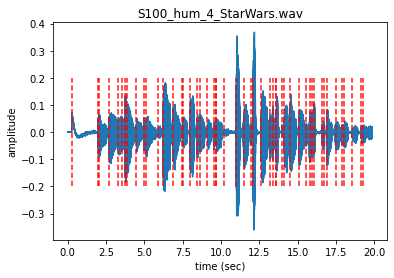

In [95]:
fs = None
n = 15
x, fs = librosa.load(files[n],sr=fs)
times = librosa.onset.onset_detect(y=x, sr=fs, units='time')
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.vlines(times, -0.20, 0.20,color='r', alpha=0.9,
           linestyle='--', label='Onsets')
title = files[n].split('\\')[-1]
plt.title(title)
plt.show()

Below I create a function that performs some data transformation. trim_audio() finds the first onset, essentially removing any silence at the beginning of the audio file, from here it takes the next 15 seconds of the track so that all subsequent arrays will be the same length for comparison. If the audiofile is less than 15 seconds, it appends 0s to the end of the file to pad the length. 

In [37]:
fs=None
x,fs=librosa.load(files[0],sr=fs)

def trim_audio(audiofile):
    times = librosa.onset.onset_detect(y=audiofile, sr=fs, units='time')
    t1 = int(times[0]*44100)
    t2 = t1+15*44100
    if len(audiofile[t1:t2])!=661500:
        audiofile = np.append(audiofile,[0]*(661500-len(audiofile[t1:t2])))
    return audiofile[t1:t2]

In [41]:
cent = librosa.feature.spectral_centroid(y=trim_audio(x), sr=fs, n_fft=7603)
len(cent[0])

1292

In [55]:
def mean_maker(cent):
    lst = []
    lst2 = []
    x = 0
    for i in range(15):
        lst.append(cent[x:x+87])
        x+=87
    for x in lst:
        lst2.append(np.mean(x))
    return lst2
test = mean_maker(cent[0])
test

[3371.1771726400125,
 5730.517400381364,
 2165.0370080289135,
 3360.195708811524,
 3190.848184198492,
 2241.236384695737,
 2045.979775609124,
 1842.7960379130877,
 1835.8912319272506,
 4784.125206171183,
 2024.6069723045262,
 2056.0388140176838,
 3215.2124709043346,
 3493.243612742076,
 1753.1992357838133]

I also investigate the use of spectral centroids on the songs of the dataset. Below are the plotted representations of each different song title's spectral centroid on a spectrogram. They are all taken from the same participant for comparison purposes. What we can see is that there are differences between each songs spectral centroids, however will the classifier be able to see each song's pattern and make accurate predictions?

In [96]:
import librosa.display
def spectro(audiofile):
    title = audiofile.split('\\')[-1]
    fs=None
    audiofile,fs = librosa.load(audiofile,sr=fs)
    audiofile = trim_audio(audiofile)
    cent = librosa.feature.spectral_centroid(y=audiofile, sr=fs, n_fft=7603)
    S, phase = librosa.magphase(librosa.stft(y=audiofile))
    librosa.feature.spectral_centroid(S=S)
    freqs, times, D = librosa.reassigned_spectrogram(audiofile, fill_nan=True)
    times = librosa.times_like(cent)
    fig, ax = plt.subplots()
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                             y_axis='log', x_axis='time',ax=ax,sr=fs,)
    ax.plot(times, cent.T, label='Spectral centroid', color='w',)
    ax.set_title(title)

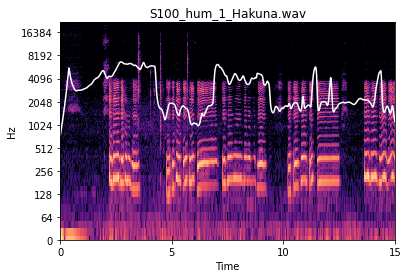

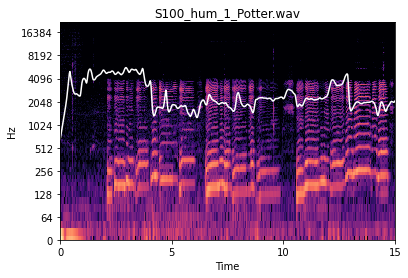

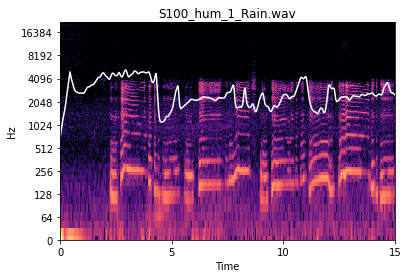

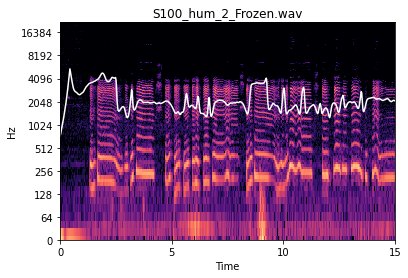

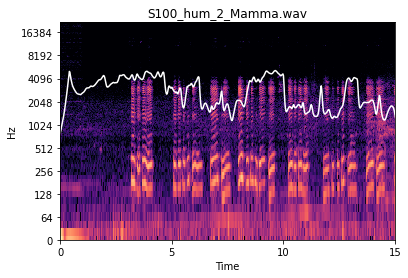

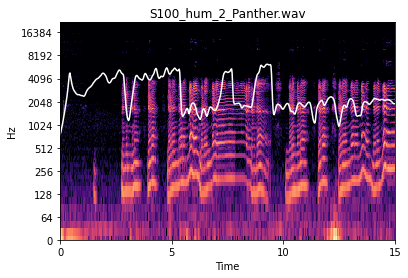

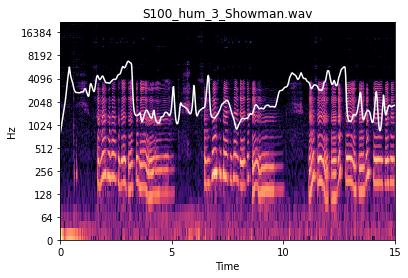

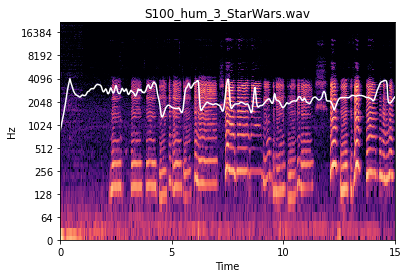

In [33]:
spectro(files[0])
spectro(files[1])
spectro(files[2])
spectro(files[3])
spectro(files[5])
spectro(files[6])
spectro(files[9])
spectro(files[10])

Below is another part of the feature extraction stage, the get_centroids() function loads the input wav file using librosa, then shortens it to 15 seconds using trim_audio, then it extracts the spectral centroids. Also within this function, it uses the previously created pandas dataframe to create the class array containing the labels of each file so that we can find how accurate our classifier is on a training and test dataset. 

In [67]:
def labeler(fileID,labels_file=MLENDHW_df):
    if labels_file.loc[fileID]['song']=='Potter':
        return 'Potter'
    elif labels_file.loc[fileID]['song']=='StarWars':
        return 'StarWars'
    elif labels_file.loc[fileID]['song']=='Hakuna':
        return 'Hakuna'
    elif labels_file.loc[fileID]['song']=='Frozen':
        return 'Frozen'
    elif labels_file.loc[fileID]['song']=='Showman':
        return 'Showman'
    elif labels_file.loc[fileID]['song']=='Rain':
        return 'Rain'
    elif labels_file.loc[fileID]['song']=='Panther':
        return 'Panther'
    else:
        return 'Mamma'

# def labeler2(fileID,labels_file=MLENDHW_df):
#     if labels_file.loc[fileID]['interpretation']=='hum':
#         return False
#     else:
#         return True

In [ ]:
def get_centroids(files, labels_file=MLENDHW_df):
    X = []
    y = []
    for file in tqdm(files):
        fileID = file.split('\\')[-1]
        file_name = file.split('\\')[-1]
        yi = labeler(fileID,labels_file=MLENDHW_df)
        #yi = labeler2(fileID,labels_file=MLENDHW_df)
        fs = None
        audiofile,fs = librosa.load(file,sr=fs)  
        audiofile = trim_audio(audiofile)
        cent = librosa.feature.spectral_centroid(y=audiofile, sr=fs)
        X.append(cent)
        y.append(yi)
    return np.squeeze(np.array(X)),y

In [64]:
def get_centroids2(files, labels_file=MLENDHW_df):
    X = []
    y = []
    for file in tqdm(files):
        fileID = file.split('\\')[-1]
        file_name = file.split('\\')[-1]
        yi = labeler(fileID,labels_file=MLENDHW_df)
        #yi = labeler2(fileID,labels_file=MLENDHW_df)
        fs = None
        audiofile,fs = librosa.load(file,sr=fs)  
        audiofile = trim_audio(audiofile)
        cent = librosa.feature.spectral_centroid(y=audiofile, sr=fs)
        cent = mean_maker(cent[0])
        X.append(cent)
        y.append(yi)
    return np.squeeze(np.array(X)),y

In [65]:
sample_path2 = '/Users/ellio/Documents/MLHW/Potter_test/*.wav'
files2 = glob.glob(sample_path2)
len(files2)

6

In [71]:
X_2,y_2 = get_centroids2(files2)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.13it/s]


In [75]:
#X_2

Using the get_centroids function results in two numpy arrays, to avoid having to run it each time for the notebook we save them to .npy files and load them in. 

In [60]:
X = np.load('X_all.npy')
y = np.load('y_all.npy')

In [61]:
X

array([[ 328.252984  ,  406.41342967,  502.96631887, ..., 1628.63579773,
        1619.64948115, 1424.7995024 ],
       [ 304.54355847,  374.05554843,  435.47651358, ..., 4997.96453613,
        5398.01687262, 5212.74377733],
       [ 322.12305485,  406.98493874,  492.41667246, ..., 2941.62181735,
        3557.54017417, 3585.87482875],
       ...,
       [2110.04117437, 2304.12001658, 2633.83501838, ..., 2578.17901788,
        2652.30226405, 2465.57216238],
       [2034.12571597, 2789.35226019, 3215.61222203, ..., 4061.83569088,
        4091.80542436, 4024.66938902],
       [2198.1675877 , 2369.01953557, 2619.82217284, ..., 2849.25504578,
        2679.76843725, 2374.55307935]])

In [ ]:
X.shape

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)
#clf.score(X_train,y_train)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,clf.predict(X_test))

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
report = np.array(precision_recall_fscore_support(y_test,clf.predict(X_test)))
#report

In [ ]:
class_report = pd.DataFrame({
    'Songs':['Frozen','Hakuna','Mamma','Panther','Potter','Rain','Showman','StarWars'],
    'Precision':report[0],
    'Recall':report[1],
    'Fscore':report[2],
    'Support':report[3],
}).set_index('Songs')
class_report

In [ ]:
X2 = X[:,::87]
X2[0]


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X2,y,test_size=0.2)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

In [ ]:
confusion_matrix(y_test,clf.predict(X_test))

In [ ]:
report = np.array(precision_recall_fscore_support(y_test,clf.predict(X_test)))
class_report = pd.DataFrame({
    'Songs':['Frozen','Hakuna','Mamma','Panther','Potter','Rain','Showman','StarWars'],
    'Precision':report[0],
    'Recall':report[1],
    'Fscore':report[2],
    'Support':report[3],
}).set_index('Songs')
class_report

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

In [ ]:
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
# clf = RandomForestClassifier()
# clf.fit(X_train,y_train)
# clf.score(X_test,y_test)
# #clf.score(X_train,y_train)

In [ ]:
# param_grid = {'max_depth': [3, 5, 10],
#              'min_samples_split': [2, 5, 10]}

In [ ]:
# clf_cv = GridSearchCV(clf, param_grid, cv=5)
# clf_cv.fit(X_train,y_train)
# print('Best hyperparameter settings: {0}.'.format(clf_cv.best_params_))
# print('Average accuracy across folds of best hyperparameter setting: {0}.'.format(clf_cv.best_score_))
# print('Test dataset accuracy of best hyperparameter setting: {0}.'.format(clf_cv.score(X_test, y_test)))